

# Additional libraries


In [ ]:
# Additional libraries for Colab
!pip install pytreebank
!pip install transformers
!pip install torchmetrics

# Import dataset SST-5

In [ ]:
import pytreebank
# load the sentiment treebank corpus in the parenthesis format,
# e.g. "(4 (2 very ) (3 good))"
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["train"][3]
# display it in the page
example.display()
print("Text format:")
print(example)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text format:
(2 (2 (2 You) (2 (2 'd) (2 (2 think) (2 (2 by) (2 now) ))))(2 (2 America) (2 (2 (2 would) (1 (2 have) (2 (2 (2 had) (1 (2 enough) (2 (2 of) (2 (2 plucky) (2 (2 British) (1 eccentrics) )))))(4 (2 with) (4 (3 hearts) (3 (2 of) (3 gold) ))))))(2 .) )))


# Models

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import InputExample, InputFeatures

# Standard model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
from transformers import BertTokenizer, AutoModelForSequenceClassification

#finetuned model  from my Hugginface repository
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("MiBo/SABERT")

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Distilled model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',  num_labels=5)

Model structure and number of parameters

In [ ]:
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

# Dataset processing

Now we define functions to extract sequences from the treebank.
There are two versions:
- Extract sequences and labels for each node of the tree
- Extract sequence and label of the root node (entire sentence)


In [ ]:
def tree_to_sequences_and_labels(tree):
  X = []
  y = []
  for s in tree.to_labeled_lines():
    X.append(s[1])
    y.append(s[0]) 
  return X, y

def tree_to_sequences_and_labels_only_root(tree):
  X = []
  y = []
  # only the first node
  for s in tree.to_labeled_lines()[:1]:
    X.append(s[1])
    y.append(s[0]) 
  return X, y

Extend the basic Dataset Pytorch class  

In [ ]:
import torch

class SST5Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Preprocessing
For each sequence:
- Tokenization
- Add special tokens such as eos
- pad the sequence until we reach the size of the longest sequence (about 60 in SST-5)
- Creation of the Attention mask (vector that indicates which tokens belong to the sentence and which are just padding)

In [ ]:
X_train = []
y_train = []

for t in dataset["train"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_train += x
  y_train += y
X_train_encodings = tokenizer(
            X_train,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
        )
train_dataset = SST5Dataset(X_train_encodings, y_train)


X_val = []
y_val = []

for t in dataset["dev"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_val += x
  y_val += y
X_val_encodings = tokenizer(
            X_val,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
        )
val_dataset = SST5Dataset(X_val_encodings, y_val)


X_test = []
y_test = []

for t in dataset["test"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_test += x
  y_test += y
X_test_encodings = tokenizer(
            X_test,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
        )
test_dataset = SST5Dataset(X_test_encodings, y_test)

# Training

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch.utils.data import DataLoader
from transformers import  AdamW
import torchmetrics
import numpy as np


# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 1

# Creation of Pytorch DataLoaders with shuffle=True for the training phase
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

#Adam algorithm optimized for tranformer architectures
optimizer = AdamW(model.parameters(), lr=1e-5)

# Setup for training with gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # initialize metric
    metric = torchmetrics.Accuracy(num_classes=5)

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode: Dropout layers are active
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Compute time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader. 
        #
        #  copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # clear any previously calculated gradients before performing a
        # backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Perform a backward pass to compute the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This helps and prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()


    # Compute the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure performance on
    # the validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode: the dropout layers behave differently
    model.eval()

    total_val_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for training.
        with torch.no_grad():        

            # Forward pass, calculate logits
            # argmax(logits) = argmax(Softmax(logits))
            outputs = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_val_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Compute the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        val_accuracy = metric(logits.softmax(dim=1), label_ids)
        

    # Report the final accuracy for this validation phase.
    # metric on all batches using custom accumulation from torchmetrics library
    val_accuracy = metric.compute()
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))

    # Compute the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

print("")
print("Training completed!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Test

In [ ]:
from torch.utils.data import DataLoader
from transformers import  AdamW
import torchmetrics
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

t0 = time.time()

# Save prediction for confusion matrix
pred = []

test_dataloader = DataLoader(test_dataset, batch_size =64, shuffle=False)

# initialize metric
metric = torchmetrics.Accuracy(num_classes=5)

# Put the model in evaluation mode: the dropout layers behave differently
model.eval()

total_test_loss = 0

# Same code of the validation phase
for batch in test_dataloader:
  
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)
        
  with torch.no_grad():        

    outputs = model(b_input_ids, 
                    attention_mask=b_input_mask,
                    labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
              
    total_test_loss += loss.item()

    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')

    batch_pred = logits.softmax(dim=1)
    pred += batch_pred.argmax(dim=1)

    test_accuracy = metric(batch_pred, label_ids)
        
test_accuracy = metric.compute()
print("Test Accuracy: {0:.3f}".format(test_accuracy))
print("")
print("Test completed!")

Test Accuracy: 0.823

Test complete!


# Confusion matrix

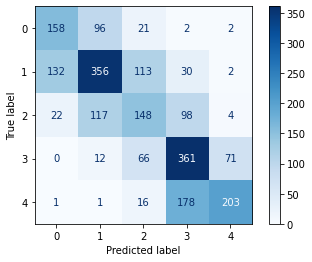

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_true = test_dataset[:]['labels']
cm = confusion_matrix(y_true, pred, labels = [0,1,2,3,4])
disp = ConfusionMatrixDisplay(cm,
                              display_labels=[0,1,2,3,4])
disp.plot(cmap="Blues", values_format='') 